# Deep Linear Networks

Here, we repeat the experiments by [Jacot et al. (2022)](https://arxiv.org/abs/2106.15933), then [estimate SLT-derived invariants like the learning coefficient](https://github.com/edmundlth/scalable_learning_coefficient_with_sgld/blob/v1.0/experiment.py).

Currently, this only looks at the learning task behind figure 3 (not the MC loss behind figure 2).

A **deep linear network** (DLN) of length $L$ is a neural network with $L$ layers of widths $n_0, \dots, n_L$, that computes the transformation:

$$
\begin{align}
f: \mathbb{R}^{n_0} &\to \mathbb{R}^{n_L} \\
x &\mapsto W_L \cdots W_1 x =: A_\theta x,
\end{align}
$$

Parametrized by $\theta \in \mathbb{R}^P$, where $P = \sum_{l=1}^L n_{l-1} n_l$ is the number of parameters.

For convenience, we consider **rectangular networks**, or $(L, w)$-DLNs, with constant hidden width $w$ across all layers: $n_1 = \dots = n_{L-1} = w$.

## Hyperparameters

- $L$ is the number of layers
- $N=n_0$ is the input dimension
- $M=n_L$ is the output dimension
- $r$ is the rank of the "true" matrix / teacher $A^*$
- $w$ or $H$ is the hidden width (for rectangular networks).
- $\sigma$ is the teacher's output noise. By default, we use $\sigma=0$.


# Set-up

- For the definition of the model `DLN`, a `torch.nn.Module`, see `devinterp.zoo.dlns.model`.
- For the definition of the dataset `DLNDataset`, a `torch.utils.data.Dataset`, see `devinterp.zoo.dlns.dataset`.

## Imports

In [5]:
from dataclasses import dataclass
import logging
import os
import sys
from typing import Callable, Dict, List
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pydantic import BaseModel
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn import functional as F
from tqdm.notebook import tqdm

if "google.colab" in sys.modules:
    %pip install git+https://github.com/timaeus-research/devinterp.git@add/colab

from devinterp.slt.sampler import estimate_rlct
from devinterp.zoo.dlns.model import DLN
from devinterp.zoo.dlns.data import DLNDataset
from devinterp.optim.sgld import SGLD

logging.basicConfig(level=logging.INFO)

sns.set_palette("deep")
sns.set_style("whitegrid")

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("deep")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("muted")[:3]

DEVICE = os.environ.get(
    "DEVICE",
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu",
)
DEVICE = torch.device(DEVICE)
NUM_CORES = int(os.environ.get("NUM_CORES", 1))
DEVICE, NUM_CORES

(device(type='cuda', index=0), 1)

In [6]:
@dataclass
class Learner:
    config: "RectangularDLNConfig"
    model: nn.Module
    dataset: torch.utils.data.Dataset
    loader: torch.utils.data.DataLoader
    optimizer: torch.optim.Optimizer
    evals: Callable[[nn.Module], Dict[str, float]]


class RectangularDLNConfig(BaseModel):
    teacher_matrix: torch.Tensor
    gamma: float = 1.1
    w: int = 100
    L: int = 4
    seed: int = 0
    noise_level: float = 1.0
    num_training_samples: int = 1024
    batch_size: int = 128
    num_steps: int = 10_000
    device: str = "cpu"
    lr: float = 1e-3
    momentum: float = 0.9
    weight_decay: float = 1e-3

    class Config:
        arbitrary_types_allowed = True

    def create_teacher(self):
        return DLN.from_matrix(self.teacher_matrix, L=1)

    def create_student(self):
        return DLN.make_rectangular(
            input_dim=self.input_dim,
            output_dim=self.output_dim,
            L=self.L,
            w=self.w,
            gamma=self.gamma,
        )

    def create_data(self, teacher: DLN):
        return DLNDataset.generate_split(
            teacher, self.num_training_samples, self.noise_level, self.seed
        )

    def create_learner(self):
        teacher = self.create_teacher()
        student = self.create_student()
        trainset, testset = self.create_data(teacher)
        trainloader = torch.utils.data.DataLoader(
            trainset, batch_size=self.batch_size, shuffle=True
        )
        evals = make_evals(teacher_matrix, trainset, testset, self.device)
        optimizer = optim.SGD(
            student.parameters(),
            lr=self.lr,
            momentum=self.momentum,
            weight_decay=self.weight_decay,
        )

        learner = Learner(self, student, trainset, trainloader, optimizer, evals)
        return learner

    @property
    def input_dim(self):
        return self.teacher_matrix.shape[1]

    @property
    def output_dim(self):
        return self.teacher_matrix.shape[0]

    def model_dump(self, *args, **kwargs):
        dump = super().model_dump(*args, **kwargs)
        dump["teacher_matrix"] = self.teacher_matrix.tolist()

        return dump


def make_evals(
    teacher_matrix: torch.Tensor, trainset: DLNDataset, testset: DLNDataset, device: str
):
    teacher_matrix = teacher_matrix.to(device)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

    def eval_mse(model, loader):
        loss = 0
        count = 0

        for x, y in loader:
            x, y = x.to(device), y.to(device)
            loss += F.mse_loss(model(x), y, reduction="sum").item()
            count += len(x)

        return loss / count

    def eval_progress(model: DLN):
        # Divide the first singular value by the first singular value of the teacher, and so on, then sum.
        # This needs a new name.
        singular_values = model.to_matrix().to("cpu").svd().S
        teacher_singular_values = teacher_matrix.to("cpu").svd().S
        missing_singular_values = teacher_singular_values == 0
        teacher_singular_values[missing_singular_values] = 1
        progress = singular_values / teacher_singular_values
        # Get rid of division by zero problems
        progress[progress == np.inf] = 0
        progress[progress == -np.inf] = 0
        progress[missing_singular_values] = 0

        return torch.sum(progress).item()

    def eval_matrix_properties(model: DLN):
        return {
            "rank": model.rank(atol=1e-1).item(),
            "ranks": [e.item() for e in model.ranks(atol=1e-1)],
            "grad_norm": model.grad_norm().item(),
            "nuc_norm": model.norm(p="nuc").item(),
            "nuc_norms": [e.item() for e in model.norms(p="nuc")],
        }

    def eval_rlct(model: DLN):
        model.to("cpu")
        rlct = estimate_rlct(
            model,
            loader=trainloader,
            criterion=F.mse_loss,
            sampling_method=SGLD,
            optimizer_kwargs=dict(
                lr=1e-4,
                temperature="adaptive",
                num_samples=len(trainset),
                elasticity=1.0,
            ),
            num_draws=10,
            num_chains=10,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            cores=NUM_CORES,
            pbar=False,
            device=torch.device("cpu"),
        )
        model.to(device)
        return rlct.item()

    def eval_rlct_repeated(model):
        results = {f"rlct/{i}": eval_rlct(model) for i in range(5)}
        rlcts = list(results.values())
        results["rlct/mean"] = np.mean(rlcts).item()
        results["rlct/std"] = np.std(rlcts).item()

        return results

    def evals(model):
        return {
            "mse/train": eval_mse(model, trainloader),
            "mse/test": eval_mse(model, testloader),
            "progress": eval_progress(model),
            **eval_matrix_properties(model),
            **eval_rlct_repeated(model),
        }

    return evals


teacher_matrix = 10.0 * torch.Tensor(np.diag([1, 2, 3, 4, 5])).detach()
config = RectangularDLNConfig(
    teacher_matrix=teacher_matrix,
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    w=100,
    L=4,
    gamma=1.0,
    noise_level=0.0,
    device=str(DEVICE),
)

In [7]:
def train(learner):
    learner.model.to(learner.config.device)
    learner.model.train()

    evals = []

    num_steps = learner.config.num_steps
    logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(
        np.logspace(0, num_steps, 50).astype(int)
    )
    print(logging_steps)

    def log(step):
        learner.model.eval()
        evals.append({"step": step, **learner.evals(learner.model)})
        # print(yaml.dump(evals[-1]))
        learner.model.train()

    step = -1
    epoch = -1

    pbar = tqdm(
        total=learner.config.num_steps,
        desc=f"Training...",
    )

    while step < learner.config.num_steps:
        torch.manual_seed(step)
        epoch += 1

        for x, y in learner.loader:
            step += 1
            x, y = x.to(learner.config.device), y.to(learner.config.device)
            learner.optimizer.zero_grad()
            y_hat = learner.model(x)
            loss = F.mse_loss(y_hat, y)
            loss.backward()
            learner.optimizer.step()

            if step in logging_steps:
                log(step=step)

            pbar.update(1)

    if pbar:
        pbar.close()

    log(step=step)

    evals_df = pd.DataFrame(evals)
    evals_df.sort_values("step", inplace=True)

    return evals_df

In [8]:
learner = config.create_learner()
df = train(learner)

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

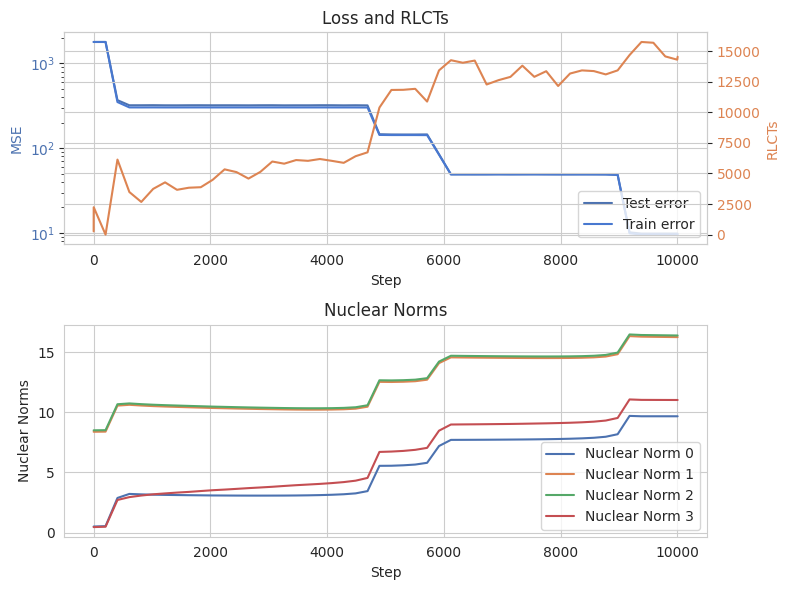

In [9]:
def plot_all(df, xlog=False, figsize=(8, 6), title=None):
    L = len(df.ranks[0])

    # Figure 1: Loss and RLCTs
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    ax1a, ax2 = axes

    ax1a.set_title(title if title else "Loss and RLCTs")

    ax1a.set_xlabel("Step")
    if xlog:
        ax1a.set_xscale("log")

    # Train error
    ax1a.plot(df.step, df["mse/test"], label="Test error", color=PRIMARY)
    ax1a.plot(df.step, df["mse/train"], label="Train error", color=PRIMARY_LIGHT)
    ax1a.set_yscale("log")
    ax1a.set_ylabel("MSE", color=PRIMARY)
    ax1a.tick_params(axis="y", labelcolor=PRIMARY)
    ax1a.legend(loc="lower right")

    # RLCTs
    ax1b = ax1a.twinx()
    rlcts = np.clip(df["rlct/mean"].to_numpy(), 0, None)
    ax1b.plot(df.step, rlcts, label="RLCTs", color=SECONDARY)
    ax1b.set_ylabel("RLCTs", color=SECONDARY)
    ax1b.tick_params(axis="y", labelcolor=SECONDARY)

    # Figure 2: Nuclear Norms
    ax2.set_title(title if title else "Nuclear Norms")
    ax2.set_xlabel("Step")
    if xlog:
        ax2.set_xscale("log")

    # Nuclear Norms
    for l in range(L):
        ax2.plot(df.step, [e[l] for e in df.nuc_norms], label=f"Nuclear Norm {l}")

    ax2.set_ylabel("Nuclear Norms")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


plot_all(df, xlog=False)

# Experiments

In [10]:
# Defining all the teacher matrices


def run_experiment(teacher_matrix: torch.Tensor, seed=None, **kwargs):
    if seed:
        torch.manual_seed(seed)

    config = RectangularDLNConfig(teacher_matrix=teacher_matrix, **kwargs)
    learner = config.create_learner()
    df = train(learner)
    return df


# Set up the teacher matrices

rk5_matrix = torch.Tensor(10 * np.diag(np.arange(1, 6)))

rk4_matrix = rk5_matrix.clone()
rk4_matrix[-1, -1] = 0

rk2_matrix = rk4_matrix.clone()
rk2_matrix[-2, -2] = 0
rk2_matrix[-3, -3] = 0

default_settings = dict(
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    w=100,
    L=4,
    gamma=1.0,
    noise_level=0.0,
    device=str(DEVICE),
)

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

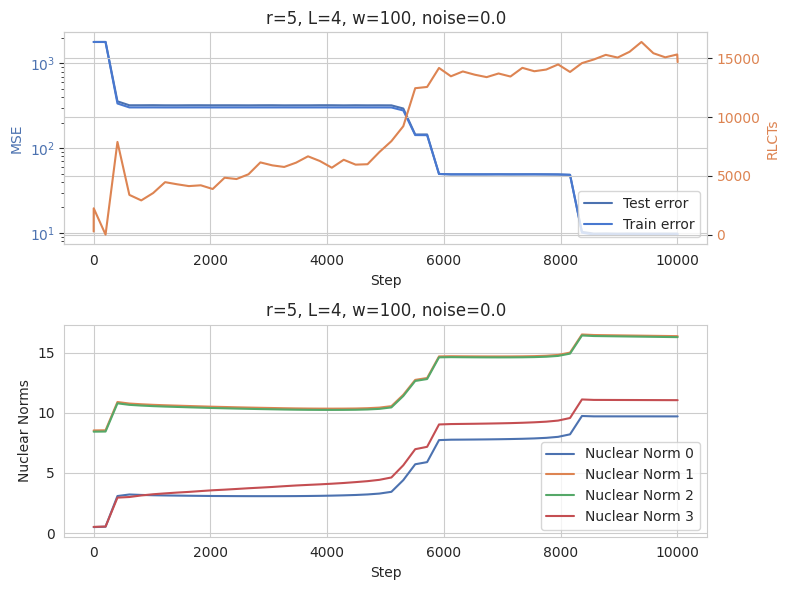

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

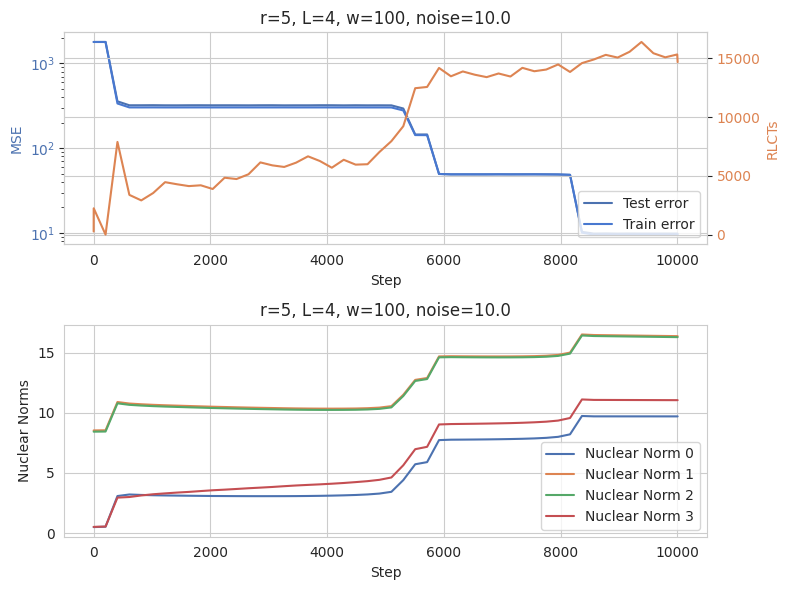

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

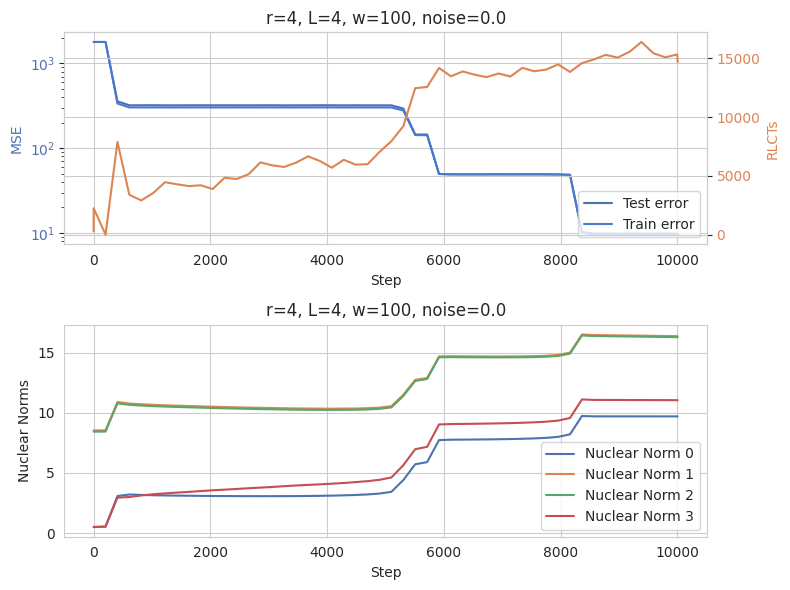

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

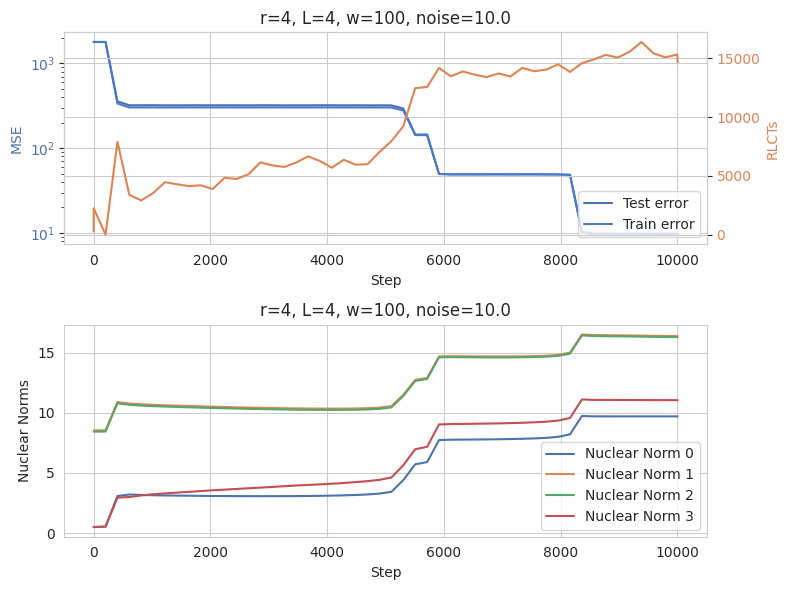

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

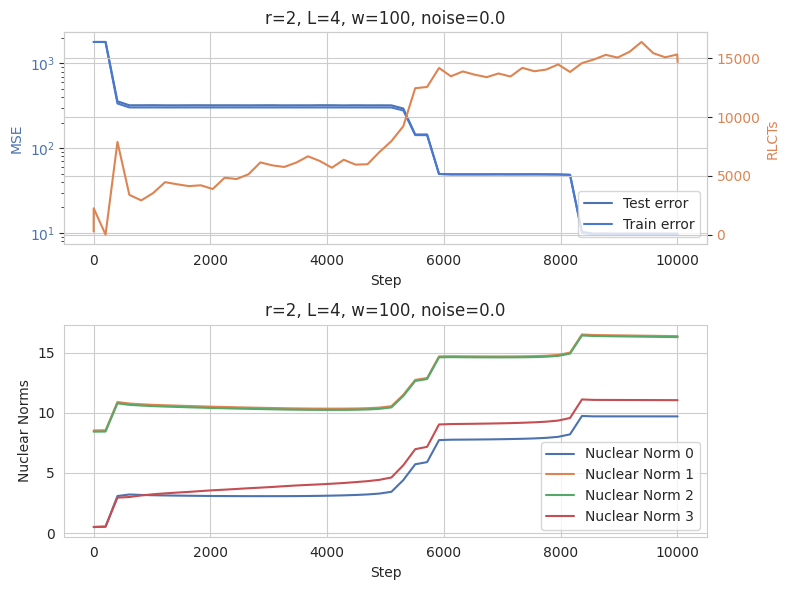

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

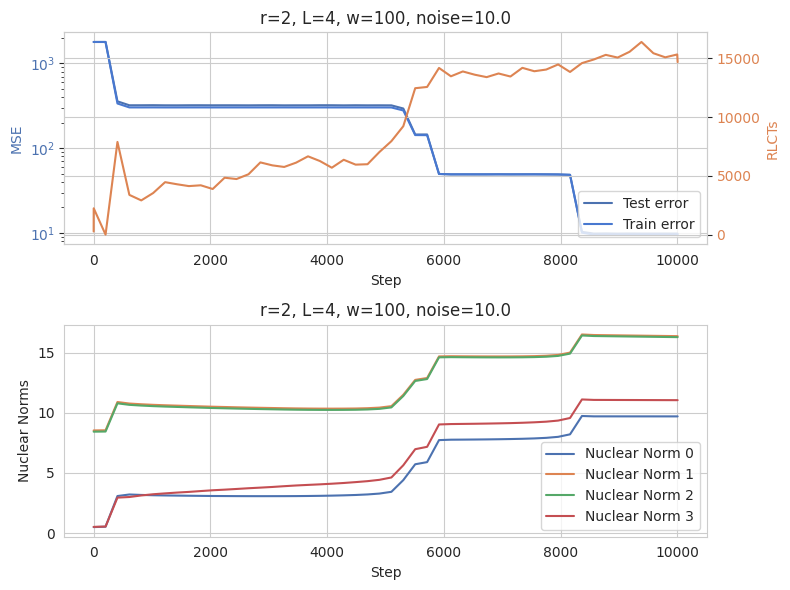

,step,mse/train,mse/test,progress,rank,ranks,grad_norm,nuc_norm,nuc_norms,rlct/0,rlct/1,rlct/2,rlct/3,rlct/4,rlct/mean,rlct/std,r,noise_level
0,0,1793.943405,1795.001495,0.000003,0,"[2, 39, 40, 3]",0.001604,0.000091,"[0.4942514896392822, 8.530783653259277, 8.4272...",-223.150028,2774.599083,-1807.291895,1766.042133,-1196.261899,262.787479,1744.658193,5,0.0
1,1,1793.943375,1795.001480,0.000003,0,"[2, 39, 40, 3]",0.001518,0.000091,"[0.4942508041858673, 8.530766487121582, 8.4272...",-414.695206,3976.477213,2516.121511,4728.110374,389.362157,2239.075210,1987.689725,5,0.0
2,204,1793.912628,1794.970932,0.000011,0,"[3, 39, 40, 3]",0.008980,0.000455,"[0.5256407856941223, 8.541681289672852, 8.4382...",-231.149997,-801.307000,-2792.865090,2891.380512,-3865.851898,-959.958694,2332.076642,5,0.0
3,408,337.179028,357.368660,0.873612,1,"[2, 40, 39, 3]",675.119019,43.680489,"[3.0759568214416504, 10.892133712768555, 10.78...",8736.947231,8164.653947,8110.218138,6346.102144,8092.614829,7890.107258,808.198457,5,0.0
4,612,303.007336,321.180901,0.859656,1,"[2, 39, 39, 3]",79.028389,42.982700,"[3.204803228378296, 10.766082763671875, 10.656...",3669.782029,3682.730470,2626.337754,3701.385182,3219.248357,3379.896758,417.793158,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,9387,9.558124,9.821047,6.493392,4,"[4, 35, 35, 4]",3.403822,139.670425,"[9.697957992553711, 16.409088134765625, 16.325...",13485.134910,15790.245938,15891.060535,15708.830567,21113.586494,16397.771689,2522.809778,2,10.0
48,9591,9.563472,9.818679,6.493273,4,"[4, 35, 34, 4]",1.740193,139.666214,"[9.697623252868652, 16.39596176147461, 16.3123...",16711.314793,15992.927945,15053.094120,14058.644822,15381.767810,15439.549898,892.546792,2,10.0
49,9795,9.558185,9.828685,6.493328,4,"[4, 35, 34, 4]",0.788537,139.668076,"[9.697425842285156, 16.38299560546875, 16.2994...",15422.075771,16107.265515,14645.868684,15536.378088,13740.887480,15090.495108,819.964979,2,10.0
50,10000,9.558318,9.826437,6.493315,4,"[4, 35, 34, 4]",2.036927,139.668808,"[9.697126388549805, 16.369873046875, 16.286411...",15921.606593,17304.287493,15334.532002,14188.575359,13918.522481,15333.504786,1228.241636,2,10.0


In [11]:
results = {}
SEED = 0

for rk, teacher_matrix in zip([5, 4, 2], [rk5_matrix, rk4_matrix, rk2_matrix]):
    for noise_level in [0.0, 10.0]:
        name = f"rk{rk}_L4_w100_noise{noise_level}"
        results[name] = run_experiment(rk5_matrix, seed=SEED, **default_settings)
        plot_all(
            results[name], xlog=False, title=f"r={rk}, L=4, w=100, noise={noise_level}"
        )

df = None

for rk, teacher_matrix in zip([5, 4, 2], [rk5_matrix, rk4_matrix, rk2_matrix]):
    for noise_level in [0.0, 10.0]:
        _df = pd.DataFrame(results[f"rk{rk}_L4_w100_noise{noise_level}"])
        _df["r"] = rk
        _df["noise_level"] = noise_level

        df = pd.concat([df, _df]) if df is not None else _df

df

# Recreate figure 5

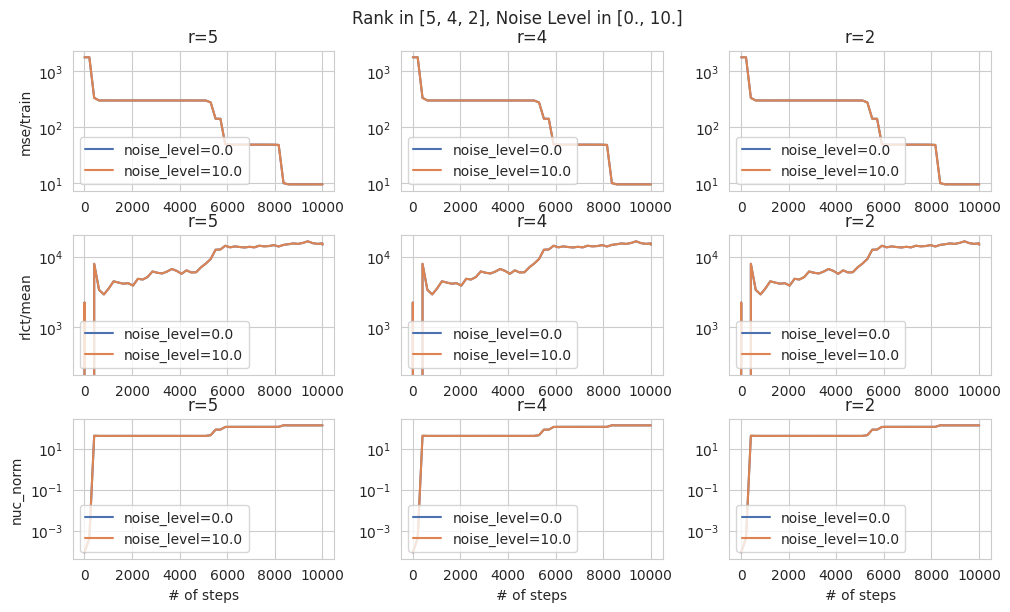

In [12]:
def plot_grid(
    df,
    x_axis: str,
    z_axis: str,
    metrics: List[str],
    title: str,
    logscale: bool = True,
    inset=False,
    figsize=(10, 6),
):
    xs = df[x_axis].unique()
    zs = df[z_axis].unique()

    # Define the colors for each w value
    colors = [PRIMARY, SECONDARY, TERTIARY]

    # Create a figure with 3 subplots (one for each gamma)
    fig, axes = plt.subplots(len(metrics), 3, figsize=figsize)
    fig.suptitle(title)

    fig.tight_layout()

    # Iterate through the unique gammas
    for i, x in enumerate(xs):
        for j, metric in enumerate(metrics):
            axes[j, 0].set_ylabel(metric)
            axes[-1, i].set_xlabel("# of steps")

            ax = axes[j, i]
            # Add an inset focusing on the first 2000 steps
            ax_inset = ax.inset_axes([0.65, 0.7, 0.3, 0.25])

            for k, z in enumerate(zs):
                data = df[(df[x_axis] == x) & (df[z_axis] == z)]
                color = colors[k]

                # Plot the training error against the number of steps
                ax.plot(data.step, data[metric], color=color, label=f"{z_axis}={z}")

                inset_data = data.loc[data.step < 2000]
                ax_inset.plot(inset_data.step, inset_data[metric], color=color)

            ax_inset.yaxis.set_visible(False)
            ax_inset.xaxis.set_visible(False)

            if logscale:
                ax_inset.set_yscale("log")
                ax.set_yscale("log")
                # ax_inset.set_xscale('log')
                # ax.set_xscale('log')

            if not inset:
                ax_inset.remove()

            ax.set_title(f"{x_axis}={x}")
            ax.legend(loc="lower left")

    plt.show()


plot_grid(
    df,
    "r",
    "noise_level",
    ["mse/train", "rlct/mean", "nuc_norm"],
    "Rank in [5, 4, 2], Noise Level in [0., 10.]",
)

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

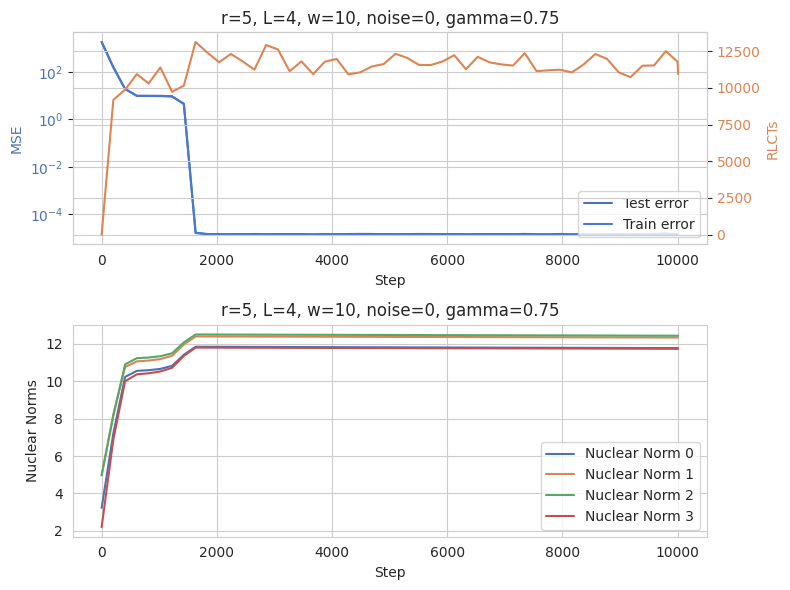

{0, 1, 6530, 5510, 4489, 3469, 2448, 10000, 8979, 1428, 7959, 408, 6938, 5918, 4897, 3877, 2857, 9387, 1836, 8367, 816, 7346, 6326, 5306, 4285, 3265, 9795, 2244, 8775, 1224, 7755, 204, 6734, 5714, 4693, 3673, 2653, 9183, 1632, 8163, 612, 7142, 6122, -9223372036854775808, 5102, 4081, 3061, 9591, 2040, 8571, 1020, 7551}


/home/paperspace/devinterp/.venv/lib/python3.9/site-packages/numpy/core/function_base.py:298: RuntimeWarning: overflow encountered in power
  return _nx.power(base, y)
/tmp/ipykernel_2926/460048890.py:8: RuntimeWarning: invalid value encountered in cast
  logging_steps = set(np.linspace(0, num_steps, 50).astype(int)) | set(np.logspace(0, num_steps, 50).astype(int))


Training...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
fig5_df = None

fig5_settings = dict(
    num_training_samples=1024,
    batch_size=128,
    num_steps=10_000,
    L=4,
    noise_level=0.0,
    device=str(DEVICE),
)

for gamma in [0.75, 1.0, 1.5]:
    # for w in [10, 100, 1000]:
    for w in [10, 100]:
        results = run_experiment(
            rk5_matrix, seed=SEED, w=w, gamma=gamma, **fig5_settings
        )
        _df = pd.DataFrame(results)
        _df["w"] = w
        _df["gamma"] = gamma
        fig5_df = pd.concat([fig5_df, _df]) if fig5_df is not None else _df
        plot_all(results, xlog=False, title=f"r=5, L=4, w={w}, noise=0, gamma={gamma}")

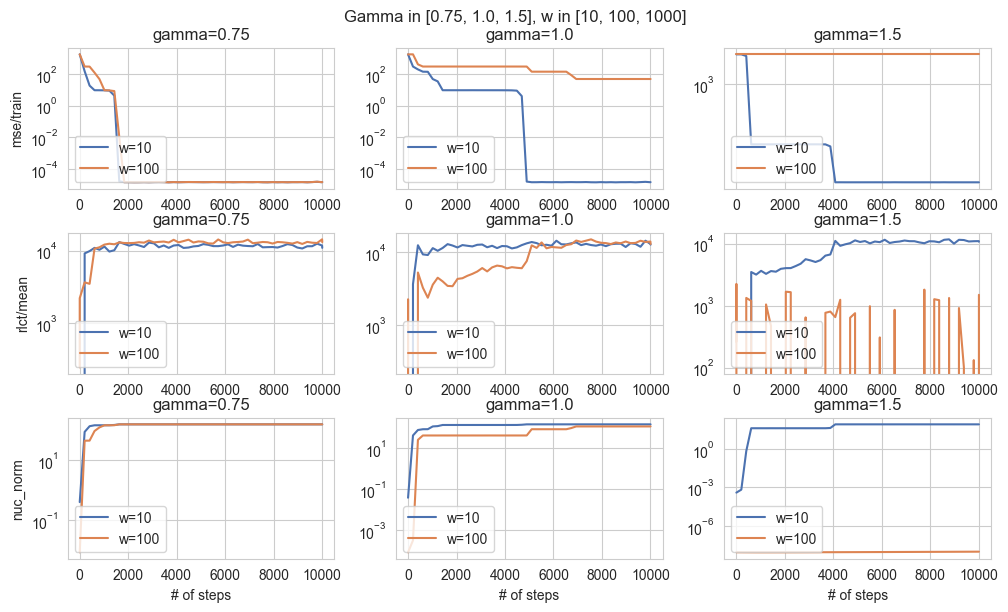

,step,mse/train,mse/test,progress,rank,ranks,grad_norm,nuc_norm,nuc_norms,rlct/0,rlct/1,rlct/2,rlct/3,rlct/4,rlct/mean,rlct/std,w,gamma
0,0,1791.990677,1792.704315,2.563742e-02,2,"[5, 8, 8, 5]",2.311612e+01,3.982359e-01,"[3.226857900619507, 4.981762409210205, 4.96184...",-282.679051,374.241270,-2357.154326,1723.124164,-1148.079717,-338.109532,1377.809430,10,0.75
1,1,1791.782745,1792.489594,2.589522e-02,2,"[5, 8, 8, 5]",2.128363e+01,4.009895e-01,"[3.2262966632843018, 4.980739116668701, 4.9624...",-170.715547,-1834.812700,-205.388378,-35.804625,-1394.328464,-728.209943,739.168595,10,0.75
2,204,151.726345,156.308018,5.917732e+00,4,"[5, 9, 8, 5]",5.564131e+01,8.441164e+01,"[7.211559295654297, 8.224806785583496, 8.16665...",9165.717851,11454.082310,8397.862605,8031.675430,8851.110910,9180.089821,1200.850578,10,0.75
3,408,18.715821,18.775866,6.477289e+00,4,"[5, 9, 8, 5]",1.241308e+01,1.299702e+02,"[10.23603343963623, 10.762702941894531, 10.908...",10622.758119,9931.878478,10051.011840,9698.652497,9092.995315,9879.459250,497.169564,10,0.75
4,612,9.538624,9.790360,6.493902e+00,4,"[5, 9, 8, 5]",1.544747e+00,1.396852e+02,"[10.560907363891602, 11.069291114807129, 11.23...",10737.191519,11318.228480,11135.712244,10299.964762,11209.738772,10940.167155,375.471788,10,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,9387,1793.943512,1795.001526,4.556682e-10,0,"[0, 0, 0, 0]",9.133596e-10,9.420888e-09,"[0.04517210274934769, 0.7670911550521851, 0.77...",-471.765697,1598.413547,-597.113128,-2080.841527,2059.324857,101.603611,1526.639230,100,1.50
48,9591,1793.943558,1795.001526,4.576354e-10,0,"[0, 0, 0, 0]",9.855250e-10,9.454997e-09,"[0.04509575292468071, 0.7655430436134338, 0.77...",-2351.069399,-3490.913761,1213.369873,-941.284080,22.150283,-1109.549417,1668.369232,100,1.50
49,9795,1793.943512,1795.001526,4.596191e-10,0,"[0, 0, 0, 0]",8.816767e-10,9.489477e-09,"[0.04501982778310776, 0.76399827003479, 0.7690...",-601.662712,-2312.027456,-1534.121376,-796.256936,5907.231117,132.632528,2949.659133,100,1.50
50,10000,1793.943497,1795.001526,4.616341e-10,0,"[0, 0, 0, 0]",1.025913e-09,9.524627e-09,"[0.04494396969676018, 0.7624496221542358, 0.76...",-1124.523031,-524.178672,-2576.892154,-425.838221,4372.045889,-55.877238,2343.510214,100,1.50


In [ ]:
plot_grid(
    fig5_df,
    "gamma",
    "w",
    ["mse/train", "rlct/mean", "nuc_norm"],
    "Gamma in [0.75, 1.0, 1.5], w in [10, 100, 1000]",
)
fig5_df